In [1]:
#!pip3 install -q torchsummary
from sklearn.model_selection import train_test_split
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
from torch.utils.data import Dataset
import cv2
from albumentations.pytorch import ToTensorV2
import albumentations as A
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
import torch

import os
from tqdm.notebook import tqdm
#from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchsummary import summary
from torchvision import transforms



In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available()  else 'cpu')


In [4]:
import os
import pandas as pd

def gather_image_data(base_dir):
    image_paths = []
    main_classes = []
    
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg", ".png")):  # Case-insensitive check
                path = os.path.join(root, file)
                image_paths.append(path)
                parts = path.split(os.sep)
                main_class = parts[-2]  # Assuming images are directly under their class directories
                main_classes.append(main_class)
                
    return image_paths, main_classes

def save_to_csv(image_paths, main_classes, csv_file):
    df = pd.DataFrame({
        'image_path': image_paths,
        'main_class': main_classes,
    })
    df.to_csv(csv_file, index=False)
    print(f'Data saved to {csv_file}')

base_dir = 'dataset_8class/'  # Make sure this is the correct path to your dataset

# Gather image data
image_paths, main_classes = gather_image_data(base_dir)
# Specify the CSV file name
csv_file = 'image_data_8class.csv'

# Save data to CSV
save_to_csv(image_paths, main_classes, csv_file)


Data saved to image_data_8class.csv


In [6]:
## create split 
df = pd.read_csv('image_data_8class.csv')
print (df)
# Assuming 'df' is your DataFrame loaded from 'image_data.csv'
main_class_le = LabelEncoder()
sub_class_le = LabelEncoder()

# Fit label encoders and transform classes to integer labels
df['main_class_encoded'] = main_class_le.fit_transform(df['main_class'])


# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)  # 20% for validation

# Optionally, save the split datasets to new CSV files (optional but useful for large datasets)
train_df.to_csv('train_data.csv', index=False)
val_df.to_csv('val_data.csv', index=False)

train_df.head()

                                           image_path         main_class
0     dataset_8class/Skin_cancer_Yes/ISIC_0028059.jpg    Skin_cancer_Yes
1     dataset_8class/Skin_cancer_Yes/ISIC_0028316.jpg    Skin_cancer_Yes
2     dataset_8class/Skin_cancer_Yes/ISIC_0028583.jpg    Skin_cancer_Yes
3     dataset_8class/Skin_cancer_Yes/ISIC_0011169.jpg    Skin_cancer_Yes
4     dataset_8class/Skin_cancer_Yes/ISIC_0029745.jpg    Skin_cancer_Yes
...                                               ...                ...
2885   dataset_8class/Breast_Cancer_Yes/yes (983).png  Breast_Cancer_Yes
2886   dataset_8class/Breast_Cancer_Yes/yes (898).png  Breast_Cancer_Yes
2887  dataset_8class/Breast_Cancer_Yes/yes (1012).png  Breast_Cancer_Yes
2888   dataset_8class/Breast_Cancer_Yes/yes (859).png  Breast_Cancer_Yes
2889   dataset_8class/Breast_Cancer_Yes/yes (905).png  Breast_Cancer_Yes

[2890 rows x 2 columns]


,image_path,main_class,main_class_encoded
2219,"dataset_8class/Lung_Cancer_No/1a,no (52).png",Lung_Cancer_No,2
965,dataset_8class/Lung_Cancer_Yes/000137.png,Lung_Cancer_Yes,3
1234,dataset_8class/Lung_Cancer_Yes/000146 (3).png,Lung_Cancer_Yes,3
662,dataset_8class/Skin_cancer_Yes/ISIC_0029323.jpg,Skin_cancer_Yes,5
2411,dataset_8class/Breast_Cancer_Yes/yes (882).png,Breast_Cancer_Yes,1


In [7]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, transform=None):
        self.image_labels = pd.read_csv(annotations_file)
        # Initialize and fit the label encoder for main classes
        self.main_class_le = LabelEncoder()
        
        # If sub_class needs encoding, initialize and fit another LabelEncoder similarly
        
        self.transform = transform

    def __len__(self):
        return len(self.image_labels)

    def __getitem__(self, idx):
        img_path = self.image_labels.iloc[idx, 0]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        main_class = self.image_labels.iloc[idx, 2]
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        return image, main_class

In [9]:
# Training transformations with more augmentations
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    #A.RandomBrightnessContrast(p=0.2),
    #A.GaussianBlur(p=0.2),
    A.Resize(256, 256),
    A.Normalize(mean=(0), std=(1)),
    ToTensorV2(),
])

# Validation transformations with minimal augmentations
val_transforms = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0), std=(1)),
    ToTensorV2(),
])

# Create dataset instances
train_dataset = CustomImageDataset(annotations_file='train_data.csv', transform=train_transforms)
val_dataset = CustomImageDataset(annotations_file='val_data.csv', transform=val_transforms)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=4)

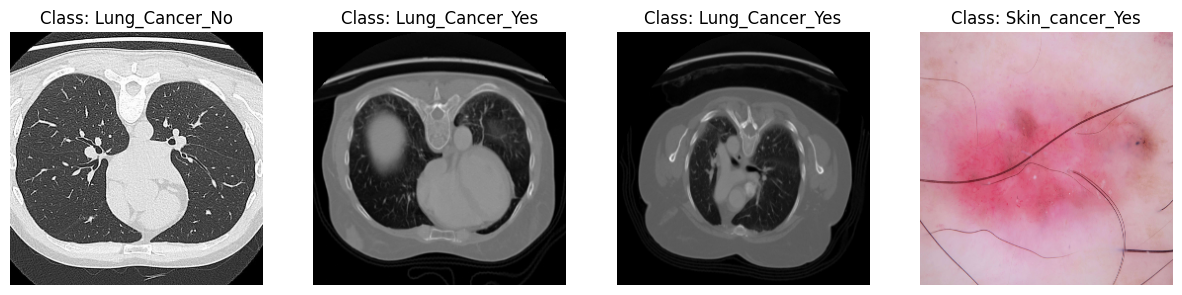

In [12]:
# import matplotlib.pyplot as plt
import numpy as np

def plot_images(dataset, main_class_le):
    """Plot images with class and subclass labels.
    
    Args:
    - dataset: A list of tuples, where each tuple contains (image, main_class, sub_class).
    - main_class_le: The LabelEncoder instance for main classes.
    - sub_class_le: The LabelEncoder instance for sub classes.
    """
    fig, axs = plt.subplots(1, len(dataset), figsize=(15, 5))
    for i, (image, main_class) in enumerate(dataset):
        # Assuming image is a PyTorch tensor, normalize and convert for display
        img_display = image.permute(1, 2, 0).numpy()
        img_display = (img_display)  # Apply reverse normalization if needed
        img_display = np.clip(img_display, 0, 1)
        
        # Reverse label encoding to get original labels
        main_class_label = main_class_le.inverse_transform([main_class])[0]
        
        axs[i].imshow(img_display)
        axs[i].set_title(f"Class: {main_class_label}")
        axs[i].axis('off')
    plt.show()

# Example usage
# Ensure you have a small dataset or a subset for demonstration
subset_dataset = [(train_dataset[i][0], train_dataset[i][1]) for i in range(4)]  # Adjust as necessary
plot_images(subset_dataset, main_class_le)

In [14]:
import timm
import torch.nn as nn

model = timm.create_model('seresnext50_32x4d', pretrained=True, num_classes=8)



model.train()

model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
num_epochs = 5
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    print(f"Start of Epoch {epoch+1} of {num_epochs}")
    total_train = 0
    correct_train = 0
    
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        #train = Variable(images.view(BATCH_SIZE, 3, 224, 224))
        #labels = Variable(labels)
        
        # Forward pass 
        outputs = model(images)
        loss = error(outputs, labels)
        
        predictions = torch.max(outputs, 1)[1].to(device)
        correct_train += (predictions == labels).sum()
        total_train += len(labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
    print(f"\nEpoch {epoch+1} of {num_epochs} Done!")
    
    # Testing the model
    
        
    total = 0
    correct = 0

    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)

#         test = Variable(images.view(BATCH_SIZE, 3, 224, 224))

        outputs = model(images)

        predictions = torch.max(outputs, 1)[1].to(device)
        predictions_list.append(predictions)
        correct += (predictions == labels).sum()

        total += len(labels)

    accuracy = correct * 100 / total
    accuracy_train = correct_train * 100 / total_train
    loss_list.append(loss.data)
    iteration_list.append(count)
    accuracy_list.append(accuracy)
        
        
    print("Epoch: {}, Loss: {}, Accuracy_test: {:.4f}%, Accuracy_train: {:.4f}%".format(epoch+1, loss.data, accuracy,accuracy_train))

Start of Epoch 1 of 5

Epoch 1 of 5 Done!
Epoch: 1, Loss: 0.015832794830203056, Accuracy_test: 86.3322%, Accuracy_train: 96.8426%
Start of Epoch 2 of 5

Epoch 2 of 5 Done!
Epoch: 2, Loss: 0.0016861227340996265, Accuracy_test: 89.9654%, Accuracy_train: 96.4965%
Start of Epoch 3 of 5

Epoch 3 of 5 Done!
Epoch: 3, Loss: 0.006640943698585033, Accuracy_test: 92.9066%, Accuracy_train: 97.3183%
Start of Epoch 4 of 5

Epoch 4 of 5 Done!
Epoch: 4, Loss: 0.014618432149291039, Accuracy_test: 94.8097%, Accuracy_train: 97.3616%
Start of Epoch 5 of 5

Epoch 5 of 5 Done!
Epoch: 5, Loss: 0.03750869259238243, Accuracy_test: 95.5017%, Accuracy_train: 98.7457%
